In [1]:
# poly narmax of steam drum system - predict water level

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sysidentpy.polynomial_basis import PolynomialNarmax
from sysidentpy.metrics import root_relative_squared_error
from pandas_ods_reader import read_ods
import pandas as pd
pd.set_option('display.max_columns', 1000)

In [3]:
df = read_ods('../data/MI-walczak.ods', 7)
column_names = df.columns

time_col = df['Time']
drum_pr = df[column_names[3]]
time_col = time_col[2:]
drum_pr = drum_pr[2:]

In [4]:
print(df['oxygen'])

0       poziom tlenu
1                [%]
2               2.33
3               2.31
4                2.3
            ...     
8997            2.21
8998            2.22
8999            2.24
9000            2.25
9001            2.27
Name: oxygen, Length: 9002, dtype: object


In [5]:
try:
    df.drop([0,1],axis=0, inplace=True)
except:
    print("no indexes 0,1")
df.reset_index(drop=True, inplace=True)
print(df['oxygen'])

0       2.33
1       2.31
2        2.3
3       2.29
4       2.28
        ... 
8995    2.21
8996    2.22
8997    2.24
8998    2.25
8999    2.27
Name: oxygen, Length: 9000, dtype: object


In [6]:
print(df.columns)

Index(['Date', 'Time', 'DRUM PR', 'DRUM PR.1', 'DRUM LVL', 'Sat steam temp',
       'MS steam pressure', 'MS steam flow', 'feedwater flow A',
       'feedwater flow B', 'load', 'Furnace master controller',
       'Furnace pr Tx-A', 'Furnace pr Tx-B', 'oxygen', 'right air flow',
       'left air flow'],
      dtype='object')


In [7]:
df.shape


(9000, 17)

In [8]:
try:
    df = df.drop(['Date', 'Time'], axis=1)
except:
    print("no indexes Date, Time")

df = df.dropna()
df.shape

(8850, 15)

In [9]:
# remove_nan = df.dropna()
# print(df.shape)
# print(len(df['DRUM LVL']))

<AxesSubplot:>

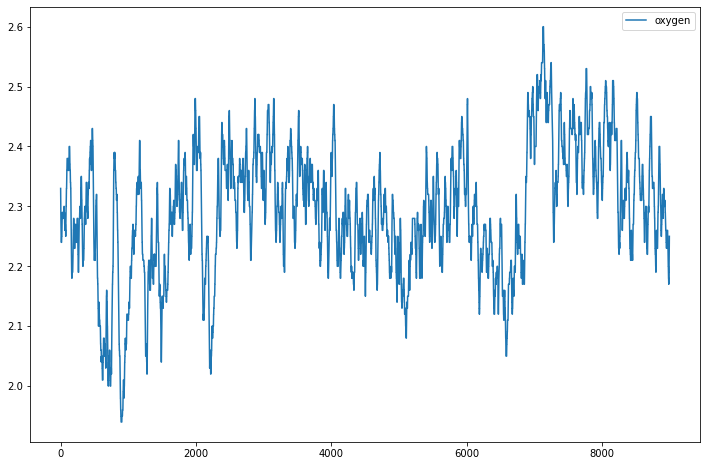

In [10]:
df[['oxygen']][0:9000].plot(figsize=(12, 8))

In [11]:
def splitData(data):
    training, evaluation = data[0:7500].values.reshape(-1, 1), data[7500::].values.reshape(-1, 1)
    training = [item for sublist in training for item in sublist] # unpack list of lists
    evaluation = [item for sublist in evaluation for item in sublist]
    return training, evaluation

def concatenateTrainingData(df, indexes):
    data_num = len(indexes)
    t_data = []
    e_data = []
    for i in indexes:
        t, e = splitData(df[i])
        t_data.append(t)
        e_data.append(e)
        
    train_data = np.concatenate([t_data], axis=1)
    evaluation_data = np.concatenate([e_data], axis=1)
    return train_data, evaluation_data
        

In [12]:
data_names = ['DRUM PR', 'DRUM PR.1', 'Sat steam temp',
       'MS steam pressure', 'MS steam flow', 'feedwater flow A',
       'feedwater flow B', 'load', 'Furnace master controller',
       'Furnace pr Tx-A', 'Furnace pr Tx-B', 'oxygen', 'right air flow',
       'left air flow']
y_name = 'DRUM LVL'
print(data_names)

['DRUM PR', 'DRUM PR.1', 'Sat steam temp', 'MS steam pressure', 'MS steam flow', 'feedwater flow A', 'feedwater flow B', 'load', 'Furnace master controller', 'Furnace pr Tx-A', 'Furnace pr Tx-B', 'oxygen', 'right air flow', 'left air flow']


In [13]:
x_train, x_eval = concatenateTrainingData(df,data_names)

In [14]:
y_train, y_eval = splitData(df[y_name])

inds = pd.isnull(df).any(1)
# print(y_eval)

In [15]:
xlags = []
for i in range (14):
    xlags.append(list(range(1, 10)))
print(xlags)

[[1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 5, 6, 7, 8, 9]]


In [16]:
x_train = np.asarray(x_train).reshape((7500,-1))
y_train = np.asarray(y_train).reshape((-1,1))
y_eval = np.asarray(y_eval).reshape((1350,-1))
x_eval = np.asarray(x_eval).reshape((-1,1))


In [17]:
model = PolynomialNarmax(# n_terms=8,
                         non_degree=1,
                         order_selection=True,
                         ylag=20, xlag=xlags,
                         n_inputs = 14,
                         n_info_values=39,
                         info_criteria='bic',
                         extended_least_squares=False,
                         estimator='least_squares')

In [18]:
model.fit(x_train, y_train)


In [19]:
print(x_eval.shape)
print(y_eval.shape)

y_hat = model.predict(x_eval, y_eval)

(18900, 1)
(1350, 1)


In [20]:

rrse = root_relative_squared_error(y_eval, y_hat)
print(rrse)
results = pd.DataFrame(model.results(err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])

4.215160027845091


In [24]:
x_eval = x_eval.reshape(1350,14)
print(x_eval.shape, y_eval.shape, y_hat.shape)
a, b,c,d = model.residuals(x_eval, y_eval, y_hat)

(1350, 14) (1350, 1) (1350, 1)


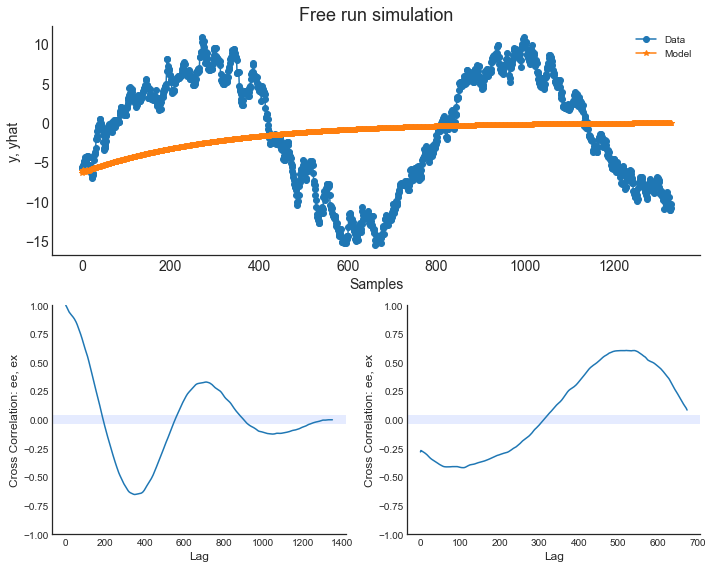

In [25]:
model.plot_result(y_eval, y_hat, a, b, n=1350)